Nesse momento, utilizaremos modelos de suavização exponencial, que utilizam pesos exponencialmente decrescentes para observações passadas, priorizando observações mais recentes. Pode ser útil para caso nossos dados mudarem ao longo do tempo, mas com alguma regularidade.

Escolheremos modelos de suavização exponencial que capturem bem a sazonalidade, pois foi uma característica observada em nossas análises.

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)

In [12]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [13]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)

MAE: 0.9474850073120882
RMSE: 0.9973095978832639
MASE: 1.5499143363252386


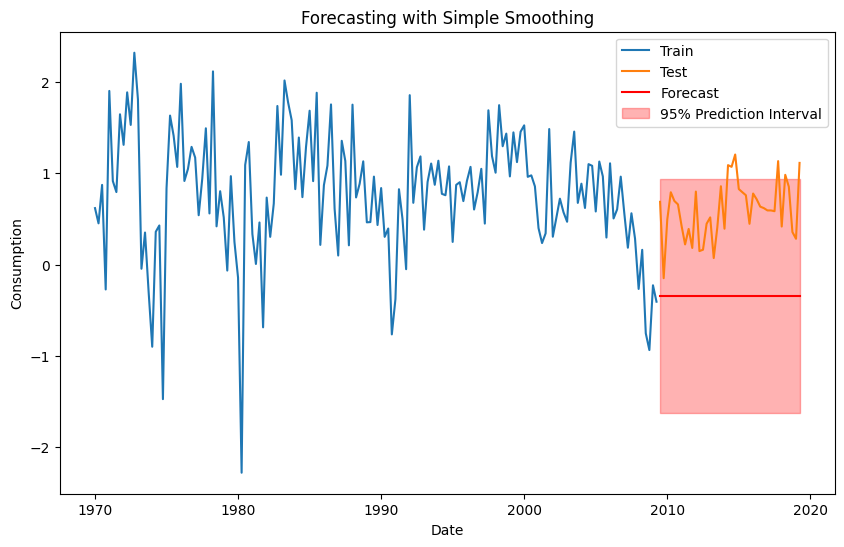

MAE: 1.0991505996456745
RMSE: 1.1526189097079322
MASE: 1.7980118514003836


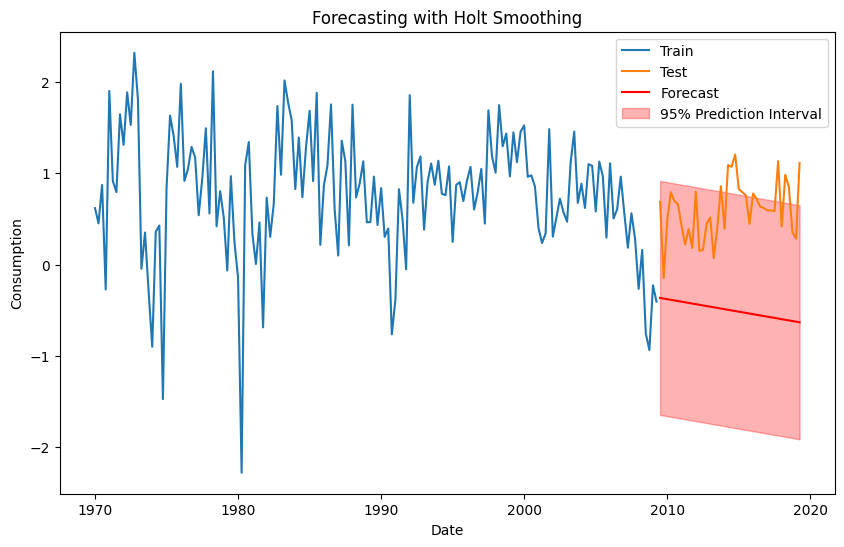

MAE: 1.0836258722260577
RMSE: 1.139798279406015
MASE: 1.7726162014328268


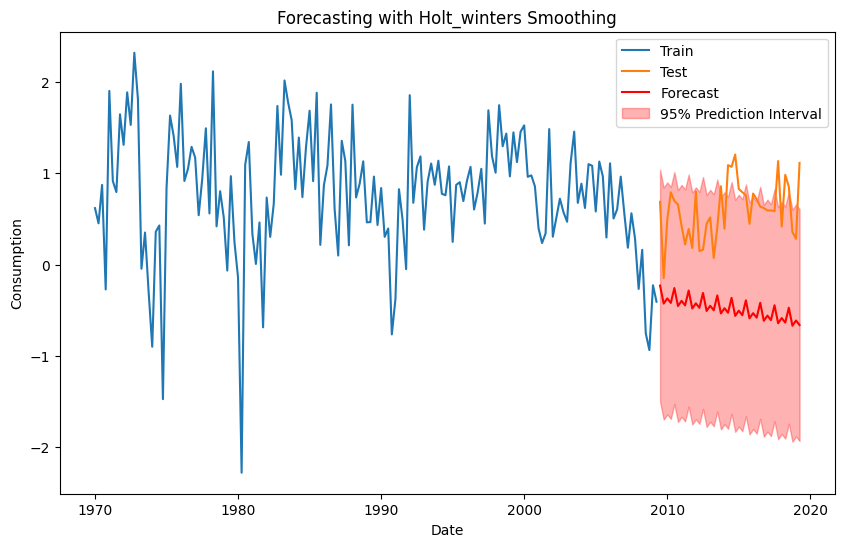

In [14]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)


def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

def fit_and_plot_smoothing(dataset, model_type="simple", seasonal="add", trend="add", seasonal_periods=12):
    """
    Function to fit an exponential smoothing strategy and plot the results,
    including the calculation of MAE, RMSE, and MASE.
    """
    
    train, test = dataset[:-40], dataset[-40:]
    
    # Escolha do modelo de suavização exponencial
    if model_type == "simple":
        model = SimpleExpSmoothing(train).fit()
    elif model_type == "holt":
        model = ExponentialSmoothing(train, trend=trend).fit()
    elif model_type == "holt_winters":
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()

    # Previsão e cálculo do intervalo de confiança
    y_pred = model.forecast(len(test))
    residuals = train - model.fittedvalues
    pred_std = np.std(residuals)  # Desvio padrão dos resíduos
    conf_interval = 1.96 * pred_std  # Intervalo de 95% assumindo normalidade

    # Cálculo de métricas de erro
    mae = mean_absolute_error(test, y_pred)
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    mase = mean_absolute_scaled_error(test, y_pred, train)
    
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    
    # Plotando série e intervalo de confiança
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(test.index, y_pred, label="Forecast", color="red")
    plt.fill_between(test.index, y_pred - conf_interval, y_pred + conf_interval, color='red', alpha=0.3, label="95% Prediction Interval")
    plt.legend()
    plt.title(f"Forecasting with {model_type.capitalize()} Smoothing")
    plt.xlabel("Date")
    plt.ylabel("Consumption")
    plt.show()

# Convertendo o índice para formato de data (para garantir compatibilidade)
Consumption.index = pd.to_datetime(Consumption.index.to_timestamp())

# Aplicando os modelos
fit_and_plot_smoothing(Consumption["Consumption"], model_type="simple")
fit_and_plot_smoothing(Consumption["Consumption"], model_type="holt", trend="add")
fit_and_plot_smoothing(Consumption["Consumption"], model_type="holt_winters", seasonal="add", seasonal_periods=4)
